In [5]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import glob
import os
from scipy.stats import binned_statistic, binned_statistic_dd


In [15]:
counts_dir = '/nesi/project/niwa00018/queenle/ML_emulator_temporal_sampling_experiments/plotting/compute_metrics/results/histogram_counts'
plot_dir = '/nesi/project/niwa00018/queenle/ML_emulator_temporal_sampling_experiments/plotting/plots/LHD'
final_figure_dir = '/nesi/project/niwa00018/queenle/ML_emulator_temporal_sampling_experiments/plotting/final_figures'


In [7]:
def get_lhd_db(h1, h2, eps=1e-12):
    h1 = np.asarray(h1)
    h2 = np.asarray(h2)
    assert h1.shape == h2.shape, "Histograms must have the same shape"
    
    mask = (h1 >= 10) & (h2 >= 10)
    h1 = h1[mask]
    h2 = h2[mask]

    log_diff_dB = 10 * (np.log10(h1) - np.log10(h2))
    lhd_db = np.sqrt(np.mean(log_diff_dB ** 2))
    
    return lhd_db

def get_lhd(h1, h2):
    # Convert to arrays in case they're lists
    h1 = np.asarray(h1)
    h2 = np.asarray(h2)
    
    assert h1.shape == h2.shape, "Histograms must have the same shape"
    
    mask = (h1 >= 10) & (h2 >= 10)
    h1 = h1[mask]
    h2 = h2[mask]
    
    return np.sum(np.abs(np.log1p(h1) - np.log1p(h2)))

def write_to_dict(result_dict,period,epoch,gcm,ml_type,framework,n,lhd_db):
    
    result_dict['period'].append(period)
    result_dict['epoch'].append(epoch)
    result_dict['GCM'].append(gcm)
    result_dict['ml_type'].append(ml_type)
    result_dict['framework'].append(framework)
    result_dict['sample_n'].append(n)
    result_dict['lhd_db'].append(lhd_db)
    
'''
LHD
'''

bins = np.arange(1, 1051, 20)

def get_lhd_df(start,end,epochs):
    
    result_dict = {'GCM':[],'ml_type':[],'framework':[],'period':[],'sample_n':[],'lhd_db':[],'epoch':[]}

    for epoch in epochs:
        for gcm in ['EC-Earth3','NorESM2-MM']:
            for ml_type in ['GAN','unet']:
                for framework in ['perfect','imperfect']:

                    df = pd.read_csv(f'{counts_dir}/{gcm}_{ml_type}_{framework}_epoch_{epoch}_{start}-{end}_histogram_counts.csv').drop('Unnamed: 0',axis=1)

                    ccam_counts = df['CCAM']

                    for i,n in enumerate(['5','10','20','30','40','50','60','80','100','120','140','1961-1980','2015-2034','2080-2099']):

                        ml_counts = df[n]

                        lhd_db = get_lhd_db(ml_counts,ccam_counts)

                        write_to_dict(result_dict,f'{start}-{end}',epoch,gcm,ml_type,framework,n,lhd_db)

    df = pd.DataFrame.from_dict(result_dict)
    
    return(df)

    

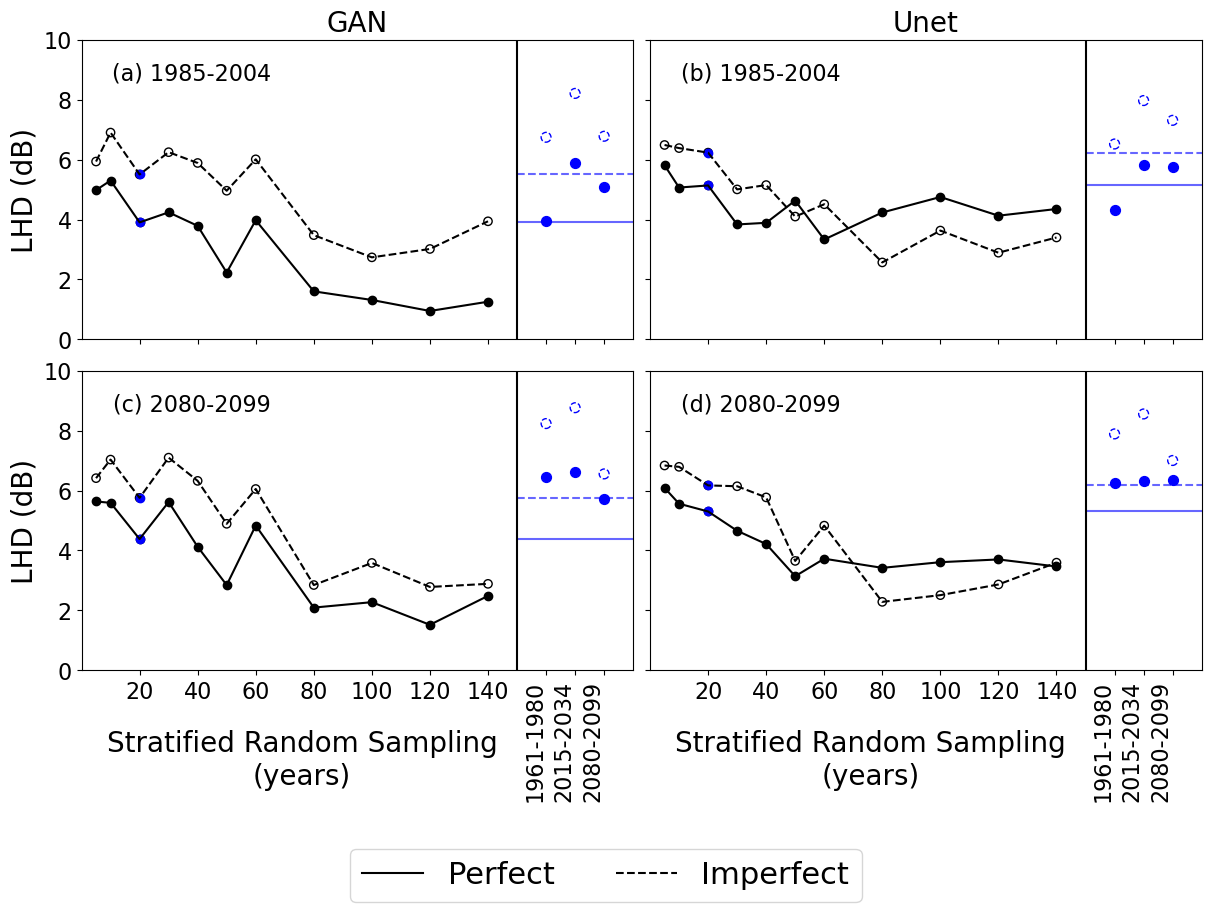

In [17]:
'''
2-GCM AND 3-epoch average
'''

colors = {'GAN':'blue','unet':'orange'}
capitalized = {'GAN':'GAN','unet':'Unet','rx1d':'Rx1d','annual_mean':'Annual Mean','DJF_mean':'DJF Mean','JJA_mean':'JJA Mean',\
               'perfect':'Perfect','imperfect':'Imperfect'}


epochs = ['220','225','230']
x_ticks = {'1961-1980':160,'2015-2034':170,'2080-2099':180}
subplot_labels = [['(a)','(b)'],
                 ['(c)','(d)']]

fig,axs = plt.subplots(2,2,figsize=(12,8),sharey=True,sharex=True,layout='constrained')

for i,period in enumerate([('1985','2004'),('2080','2099')]):

    start,end = period[0],period[1]
    
    df = get_lhd_df(start,end,epochs)

    for j,ml_type in enumerate(['GAN','unet']):

        ml_type_df = df[df['ml_type']==ml_type]

        for framework in ['perfect','imperfect']:

            framework_df = ml_type_df[ml_type_df['framework']==framework]

            gcm_dfs = []
            for gcm  in ['EC-Earth3','NorESM2-MM']:
                gcm_result = framework_df[framework_df['GCM']==gcm].groupby('sample_n').mean(numeric_only=True)['lhd_db']
                gcm_dfs.append(gcm_result)

            mean = sum(gcm_dfs)/2

            results_n = mean[~mean.index.isin(['1961-1980','2015-2034','2080-2099'])]
            results_n.index = results_n.index.astype(int)
            results_n = results_n.sort_index()

            results_20 = mean[mean.index.isin(['1961-1980','2015-2034','2080-2099'])]

            # PLOTTING

            # dashed line at 20-year random sampling
            random_20_val = results_n[20]
            #axs[i][j].hlines(random_20_val,15,25,color='red',linestyle='-' if framework=='perfect' else '--',alpha=0.6)
            axs[i][j].hlines(random_20_val,150,190,color='blue',linestyle='-' if framework=='perfect' else '--',alpha=0.6)#,label=f'{ml_type} random 20-year sample')

            # n samples
            x = [int(v) for v in results_n.index]
            axs[i][j].scatter(x,results_n,facecolors='none' if framework=='imperfect' else 'black',edgecolors='black')
            axs[i][j].plot(x,results_n,color='black',linestyle = '-' if framework=='perfect' else '--',label=f'{capitalized[framework]}')
            axs[i][j].scatter(20,random_20_val,color='blue')
            
            # 20-year samples
            for k,index in enumerate(results_20.index):
                x_val = x_ticks[index]
                axs[i][j].scatter(x_val,results_20.loc[index],s=50,facecolors='none' if framework=='imperfect' else 'blue',edgecolors='blue',linestyle = '-' if framework=='perfect' else '--')

        if i == 0:
            axs[i][j].set_title(capitalized[ml_type],fontsize=20)

        axs[i][j].text(0.2,0.85,f'{subplot_labels[i][j]} {start}-{end}', transform=axs[i][j].transAxes,ha='center', va='bottom', fontsize=16)

        # AXIS LABELS
        axs[i][j].set_ylim(0,10)
        if j == 0:
            axs[i][j].set_ylabel('LHD (dB)',fontsize=20)

        axs[i][j].axvline([150],color='black')
        axs[i][j].tick_params(axis='y', labelsize=16)
        axs[i][j].set_xlim(0,190)


        # x axis label
        if i != 0:
            axs[i][j].text(0.4, -0.3, 'Stratified Random Sampling\n(years)', va='center', ha='center',rotation='horizontal', transform=axs[i][j].transAxes,fontsize=20)

            #axs[i][j].text(0.15, -0.2, 'sample size (years)', va='center', ha='left',rotation='horizontal', transform=axs[i][j].transAxes,fontsize=20)

        # configure xticks and labels
        positions = [20, 40, 60, 80, 100, 120, 140, 160, 170, 180]
        labels = ['20', '40', '60', '80', '100', '120', '140', '1961-1980', '2015-2034', '2080-2099']

        # Set all at once
        axs[i][j].set_xticks(positions)
        axs[i][j].set_xticklabels(labels, fontsize=16)

        # Rotate only the "future period" labels
        for pos, label in zip(positions, axs[i][j].get_xticklabels()):
            if pos >= 160:
                label.set_rotation(90)
                label.set_ha('right')

#axs[0][1].legend(fontsize=16,loc=(0.4, 0.7))
handles, labels = axs[0][1].get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.14),fontsize=22)

epochs_string = '-'.join(epochs)

#plt.savefig(f'{plot_dir}/epochs_{epochs_string}_2GCM_average.png',dpi=300, bbox_inches='tight', bbox_extra_artists=(legend,))
plt.savefig(f'{final_figure_dir}/Figure4.png',dpi=300, bbox_inches='tight', bbox_extra_artists=(legend,), pad_inches=0.5)


In [18]:
labels

['20',
 '40',
 '60',
 '80',
 '100',
 '120',
 '140',
 '1961-1980',
 '2015-2034',
 '2080-2099']

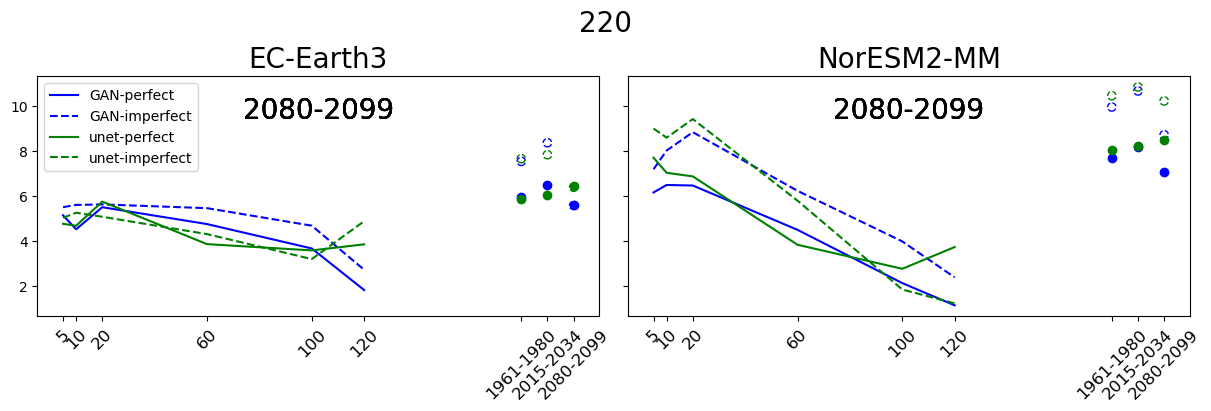

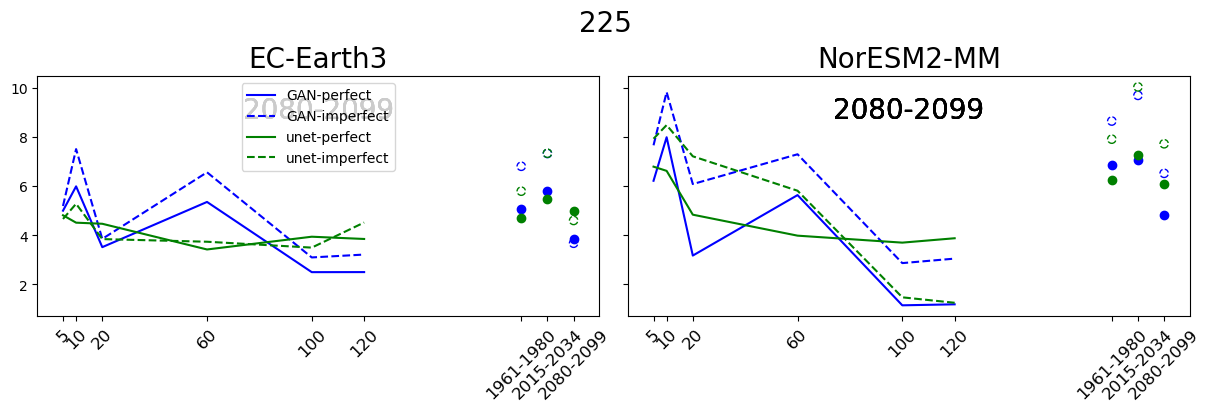

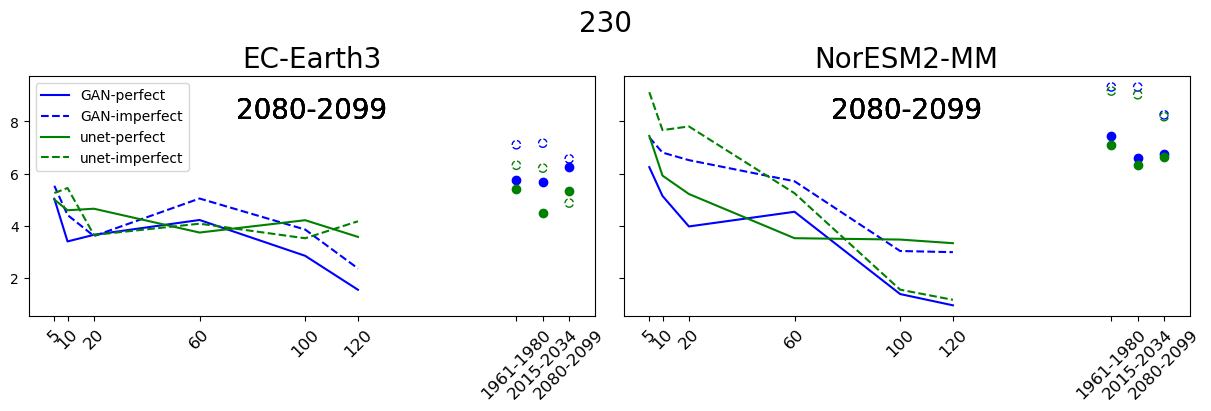

In [16]:
#period_dict = {'historic':[('1985','1989'),('1985','2004')],'future':[('2080','2084'),('2080','2099')]}

start,end = ('2080','2099')
colors = {'GAN':'blue','unet':'green'}

epochs = [220,225,230]

df = get_lhd_df(start,end,epochs)

for epoch in epochs:
    
    fig,axs = plt.subplots(1,2,figsize=(12,4),sharey=True,sharex=True,layout='constrained')

    for j,gcm in enumerate(['EC-Earth3','NorESM2-MM']):

        for ml_type in ['GAN','unet']:

            for framework in ['perfect','imperfect']:
                
                current_df = (df[(df['ml_type']==ml_type) & (df['framework']==framework) & (df['GCM']==gcm) & (df['epoch']==epoch)])
                
                # n-samplings
                df_n = current_df[~current_df['sample_n'].isin(['1961-1980','2015-2034','2080-2099'])]
                vals = df_n['lhd_db']
                x_n = df_n['sample_n']
                
                axs[j].plot([int(v) for v in x_n],vals,color='blue' if ml_type == 'GAN' else 'green',linestyle = '-' if framework=='perfect' else '--',label=f'{ml_type}-{framework}')

                # 20-yr samplings
                df_20 = current_df[current_df['sample_n'].isin(['1961-1980','2015-2034','2080-2099'])]
                vals = df_20['lhd_db']
                x_20 = df_20['sample_n']
                
                axs[j].scatter([180,190,200],vals,facecolors='none' if framework == 'imperfect' else colors[ml_type],edgecolors=colors[ml_type],linestyle = '-' if framework=='perfect' else '--')

                axs[j].set_xticks([int(v) for v in x_n] + [180,190,200],labels=x_n.values.tolist() + x_20.values.tolist(),fontsize=12,rotation=45)


                axs[j].set_title(gcm,fontsize=20)

                axs[j].text(0.5,0.8,f'{start}-{end}', transform=axs[j].transAxes,ha='center', va='bottom', fontsize=20)


    axs[0].legend()
    plt.suptitle(f'{epoch}',fontsize=20)

        
        
        


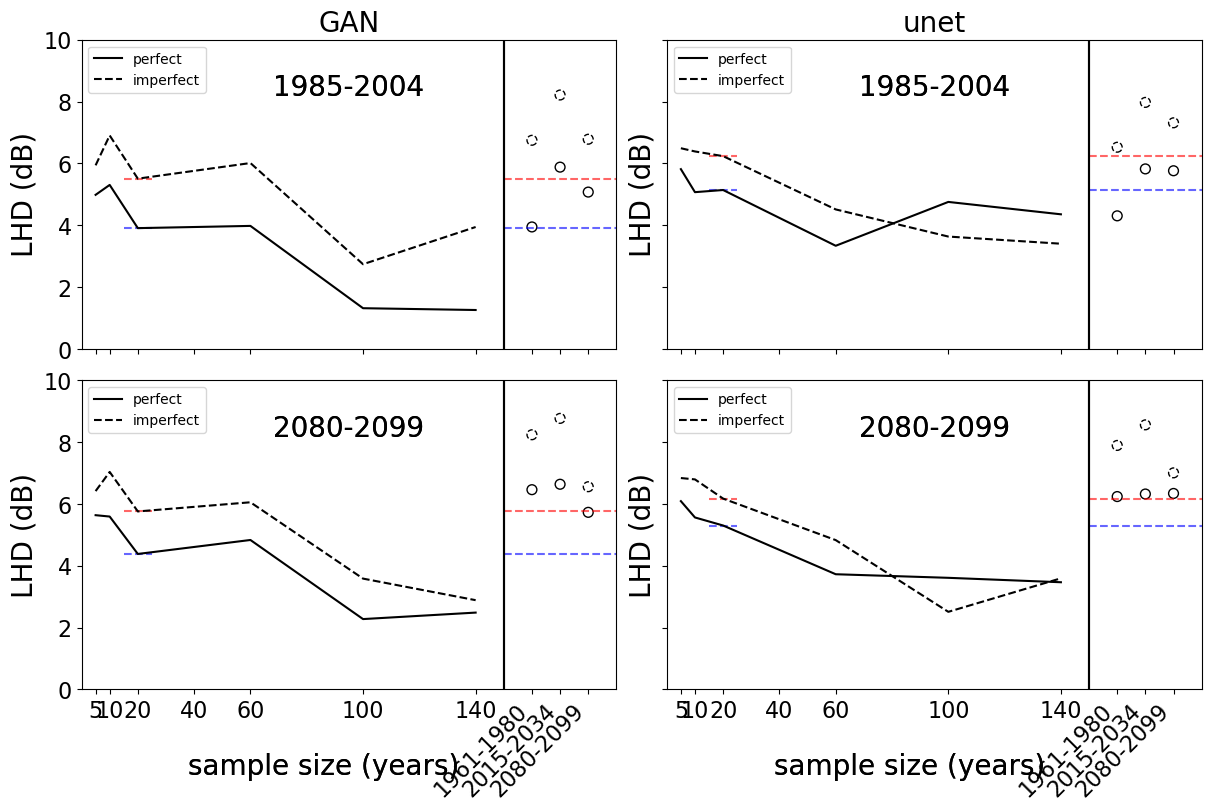

In [12]:
df

,GCM,ml_type,framework,period,sample_n,lhd_db,epoch
0,EC-Earth3,GAN,perfect,2080-2099,5,5.133847,220
1,EC-Earth3,GAN,perfect,2080-2099,10,4.509260,220
2,EC-Earth3,GAN,perfect,2080-2099,20,5.493349,220
3,EC-Earth3,GAN,perfect,2080-2099,60,4.741632,220
4,EC-Earth3,GAN,perfect,2080-2099,100,3.653833,220
...,...,...,...,...,...,...,...
211,NorESM2-MM,unet,imperfect,2080-2099,100,1.549780,230
212,NorESM2-MM,unet,imperfect,2080-2099,140,1.533227,230
213,NorESM2-MM,unet,imperfect,2080-2099,1961-1980,9.167520,230
214,NorESM2-MM,unet,imperfect,2080-2099,2015-2034,9.026659,230
